## The Hodgkin-Huxley Model

In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 

import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from IPython.display import display
#from latex_envs.latex_envs import figcaption 
from matplotlib import gridspec
from tqdm import tqdm_notebook as tqdm

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rc('text', usetex=True)

sns.set(context="paper", style='whitegrid', rc={"axes.facecolor": "0.99"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class ConstantStimulus:
    def __init__(self, I_amp, t_stim_on, t_stim_off):
        self.I_amp = I_amp
        self.t_stim_on = t_stim_on
        self.t_stim_off = t_stim_off

    def __call__(self, t):
        return self.I_amp if self.t_stim_on <= t <= self.t_stim_off else 0

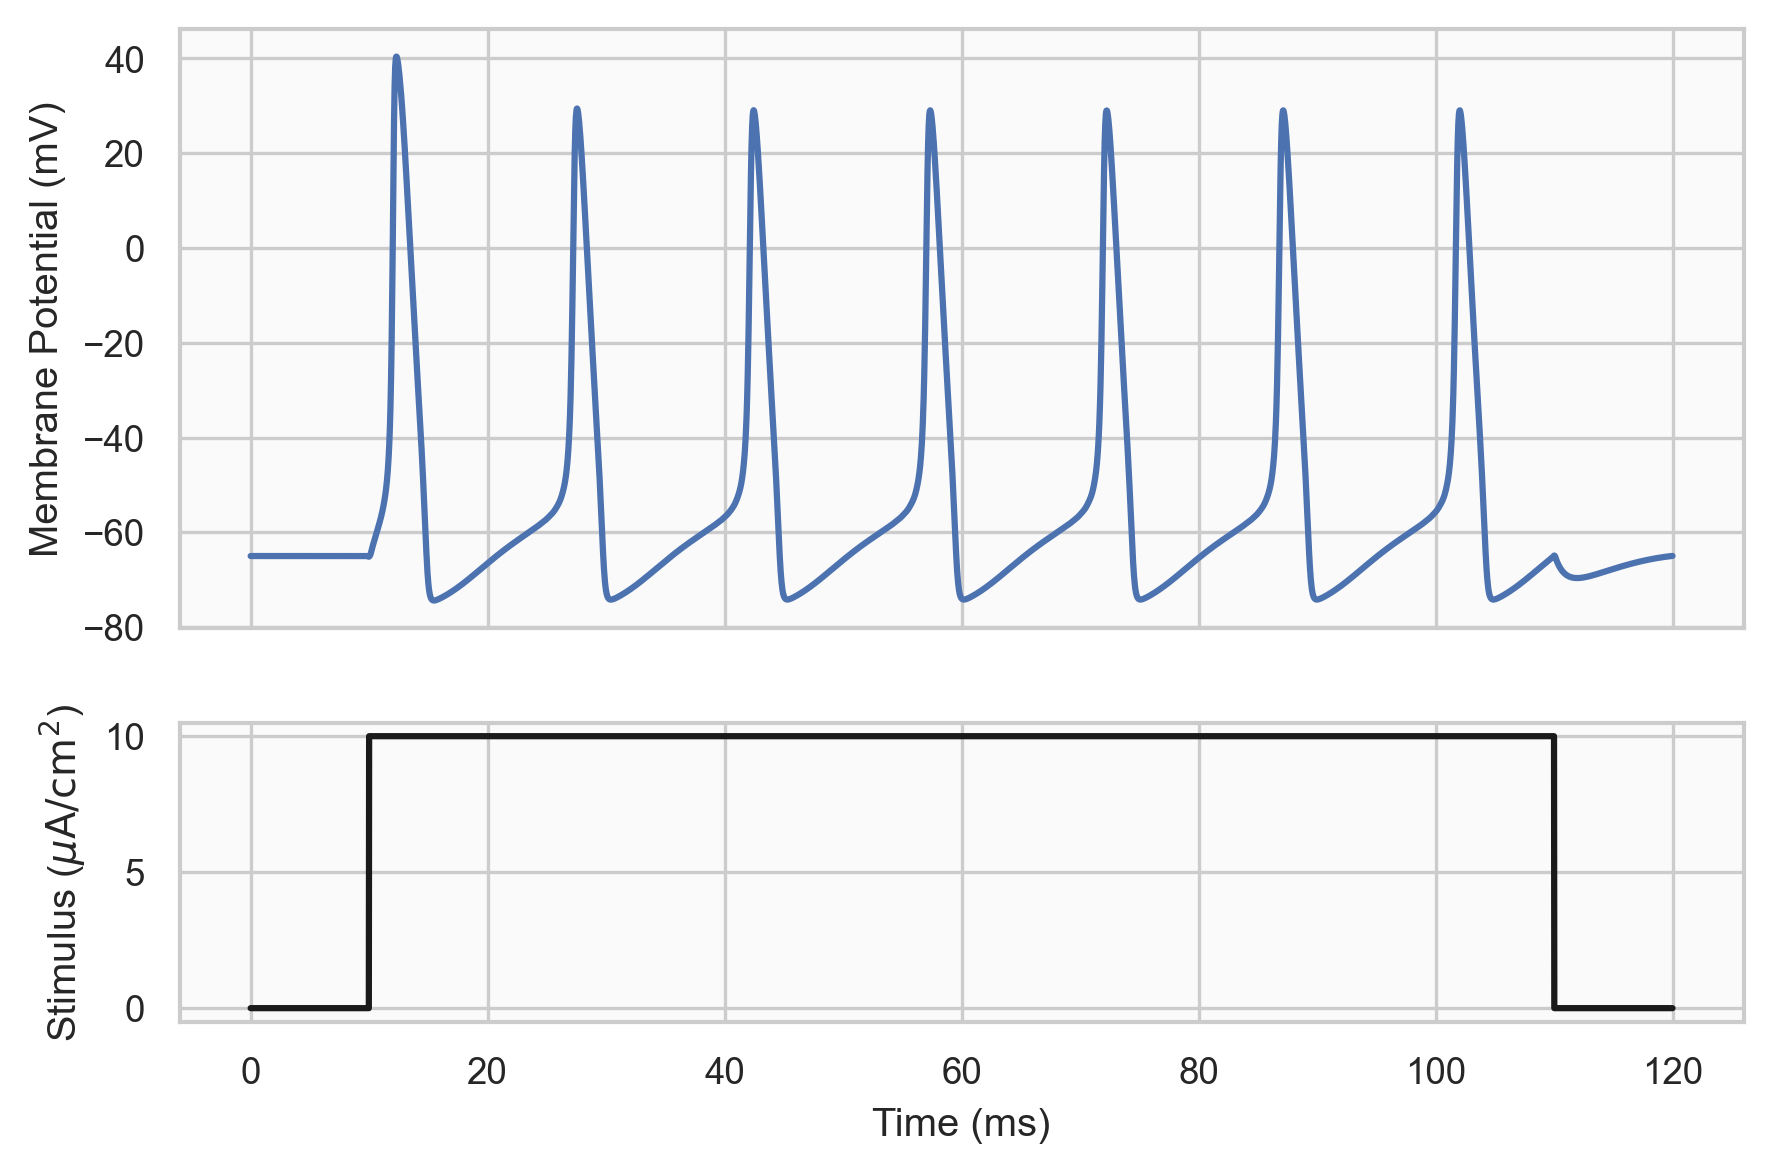

In [3]:
T = 120     # Simulation time [ms]
dt = 0.025  # Time step
I_amp = 10
t_stim_on = 10
t_stim_off = 110

stimulus = ConstantStimulus(I_amp, t_stim_on, t_stim_off)

hh = nm.models.HodgkinHuxley(stimulus, T, dt)

V, t = hh(gbar_K=36., gbar_Na=120.)

hh.plot_voltage_trace(with_stim=True)
plt.show()

In [4]:
# Spike statistics, callable instance
stats = ["spike_rate",
         "latency_to_first_spike",
         "average_AP_overshoot",
         "average_AHP_depth",
         "average_AP_width",
         "accommodation_index"]

# Spike statistics, class methods
print("SPIKE STATS")
sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on, t_stim_off=t_stim_off)

# number of spikes
n_spikes = sps.n_spikes(V, t)
print(f"{n_spikes=}")

# spike rate
spike_rate = sps.spike_rate(V, t)
print(f"{spike_rate=:.4f} mHz")

# latency to first spike
latency_to_first_spike = sps.latency_to_first_spike(V, t)
print(f"{latency_to_first_spike=:.4f} ms")

# average AP overshoot
average_AP_overshoot = sps.average_AP_overshoot(V, t)
print(f"{average_AP_overshoot=:.4f} mV")

# average AHP depth
average_AHP_depth = sps.average_AHP_depth(V, t)
print(f"{average_AHP_depth=:.4f} mV")

# average AP width
average_AP_width = sps.average_AP_width(V, t)
print(f"{average_AP_width=:.4f} mV")

# accommodation index
accommodation_index = sps.accommodation_index(V, t)
print(f"{accommodation_index=:.4f}")

SPIKE STATS
n_spikes=7
spike_rate=0.0700 mHz
latency_to_first_spike=2.3000 ms
average_AP_overshoot=30.7316 mV
average_AHP_depth=-63.6200 mV
average_AP_width=2.0501 mV
accommodation_index=0.0000


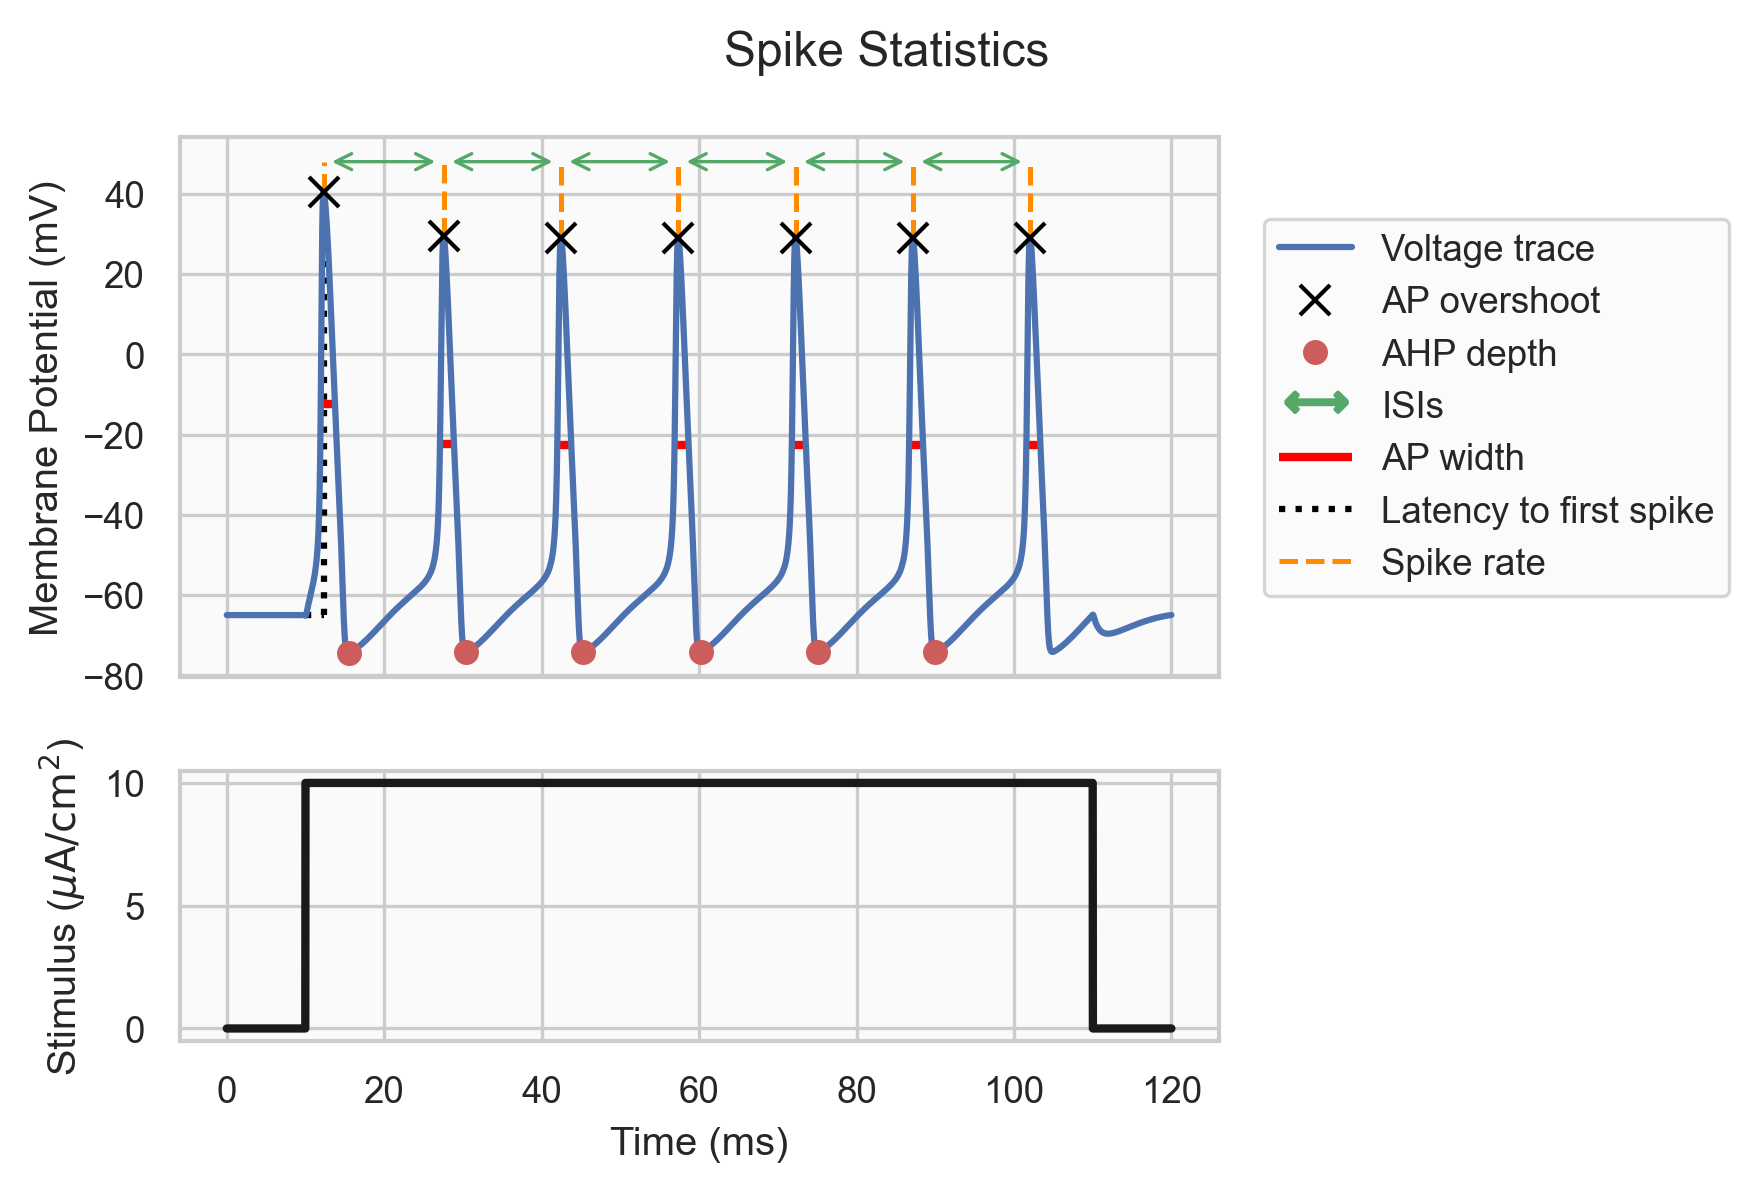

In [5]:
hh.plot_spike_statistics(t_stim_on, t_stim_off)
plt.show()

In [6]:
sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on, t_stim_off=t_stim_off, stats=stats)

stats = ["n_spikes",
         "spike_rate",
         "latency_to_first_spike",
         "average_AP_overshoot",
         "average_AHP_depth",
         "average_AP_width",
         "accommodation_index"]

sum_stats = hh.stats_df(t_stim_on, t_stim_off, stats=stats)
sum_stats

,Statistic,Value
0,Number of spikes,7.000000e+00
1,Spike rate,7.000000e-02
2,Latency to first spike,2.300000e+00
3,Average AP overshoot,3.073156e+01
4,Average AHP depth,-6.362005e+01
5,Average AP width,2.050133e+00
6,Accommodation index,2.384372e-17


In [7]:
# simulation parameters
T = 120     # Simulation time [ms]
dt = 0.025  # Time step
I_amp = 10
t_stim_on = 10
t_stim_off = 110
stimulus = ConstantStimulus(I_amp, t_stim_on, t_stim_off)

# model parameters
N = 100
gbar_K_fixed = 36
gbar_Na_fixed = 120 

gbar_Ks = np.linspace(26, 46, N)
gbar_Nas = np.linspace(110, 130, N)

# simulator model
hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# statistics calculator 
stats = ["n_spikes",
         "spike_rate",
         "latency_to_first_spike",
         "average_AP_overshoot",
         "average_AHP_depth",
         "average_AP_width",
         "accommodation_index"]
sps = nm.statistics.SpikeStats(t_stim_on, t_stim_off, stats=stats)

In [36]:
stats_data_gbar_K = {stat: [] for stat in stats}
V_mean_gbar_K = []
for gbar_K in tqdm(gbar_Ks):
    V, t = hh(gbar_K, gbar_Na_fixed)
    V_mean_gbar_K.append(np.mean(V[(t > t_stim_on) & (t < t_stim_off)]))
    sum_stats = sps(V, t)
    for i, key in enumerate(stats_data_gbar_K):
        stats_data_gbar_K[key].append(sum_stats[i])

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
stats_data_gbar_Na = {stat: [] for stat in stats}
V_mean_gbar_Na = []
for gbar_Na in tqdm(gbar_Nas):
    V, t = hh(gbar_K_fixed, gbar_Na)
    V_mean_gbar_Na.append(np.mean(V[(t > t_stim_on) & (t < t_stim_off)]))
    sum_stats = sps(V, t)
    for i, key in enumerate(stats_data_gbar_Na):
        stats_data_gbar_Na[key].append(sum_stats[i])

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
df_gbar_K = pd.DataFrame.from_dict(stats_data_gbar_K)
df_gbar_K["gbar_K"] = gbar_Ks
df_gbar_K["V_mean"] = V_mean_gbar_K
df_gbar_K.head()

,n_spikes,spike_rate,latency_to_first_spike,average_AP_overshoot,average_AHP_depth,average_AP_width,accommodation_index,gbar_K,V_mean
0,8,0.08,2.275,33.959973,-64.266192,2.152194,-1.632387e-04,26.000000,-50.404599
1,8,0.08,2.300,33.929557,-64.285613,2.151207,6.938894e-17,26.202020,-50.437838
2,8,0.08,2.225,33.883757,-64.304214,2.161738,-1.622850e-04,26.404040,-50.472328
3,8,0.08,2.200,33.854710,-64.322978,2.155499,1.619695e-04,26.606061,-50.505660
4,8,0.08,2.275,33.809596,-64.340968,2.157929,0.000000e+00,26.808081,-50.535867


In [39]:
df_gbar_Na = pd.DataFrame.from_dict(stats_data_gbar_Na)
df_gbar_Na["gbar_Na"] = gbar_Nas
df_gbar_Na["V_mean"] = V_mean_gbar_Na
df_gbar_Na.head()

,n_spikes,spike_rate,latency_to_first_spike,average_AP_overshoot,average_AHP_depth,average_AP_width,accommodation_index,gbar_Na,V_mean
0,6,0.06,2.3,26.403282,-61.753240,1.665784,-1.074951e-16,110.000000,-54.417151
1,7,0.07,2.3,26.005419,-63.512657,1.897401,7.581501e-04,110.202020,-54.372905
2,7,0.07,2.3,26.274960,-63.516072,1.892478,-2.170573e-17,110.404040,-54.298137
3,7,0.07,2.3,26.498719,-63.519354,1.912094,-4.358493e-17,110.606061,-54.105230
4,7,0.07,2.3,26.738715,-63.522654,1.936848,-4.379308e-17,110.808081,-53.806306


Summary statistics versus model parameters. Each plot is generated by varying one parameter while the others are held fixed to the values in [table]

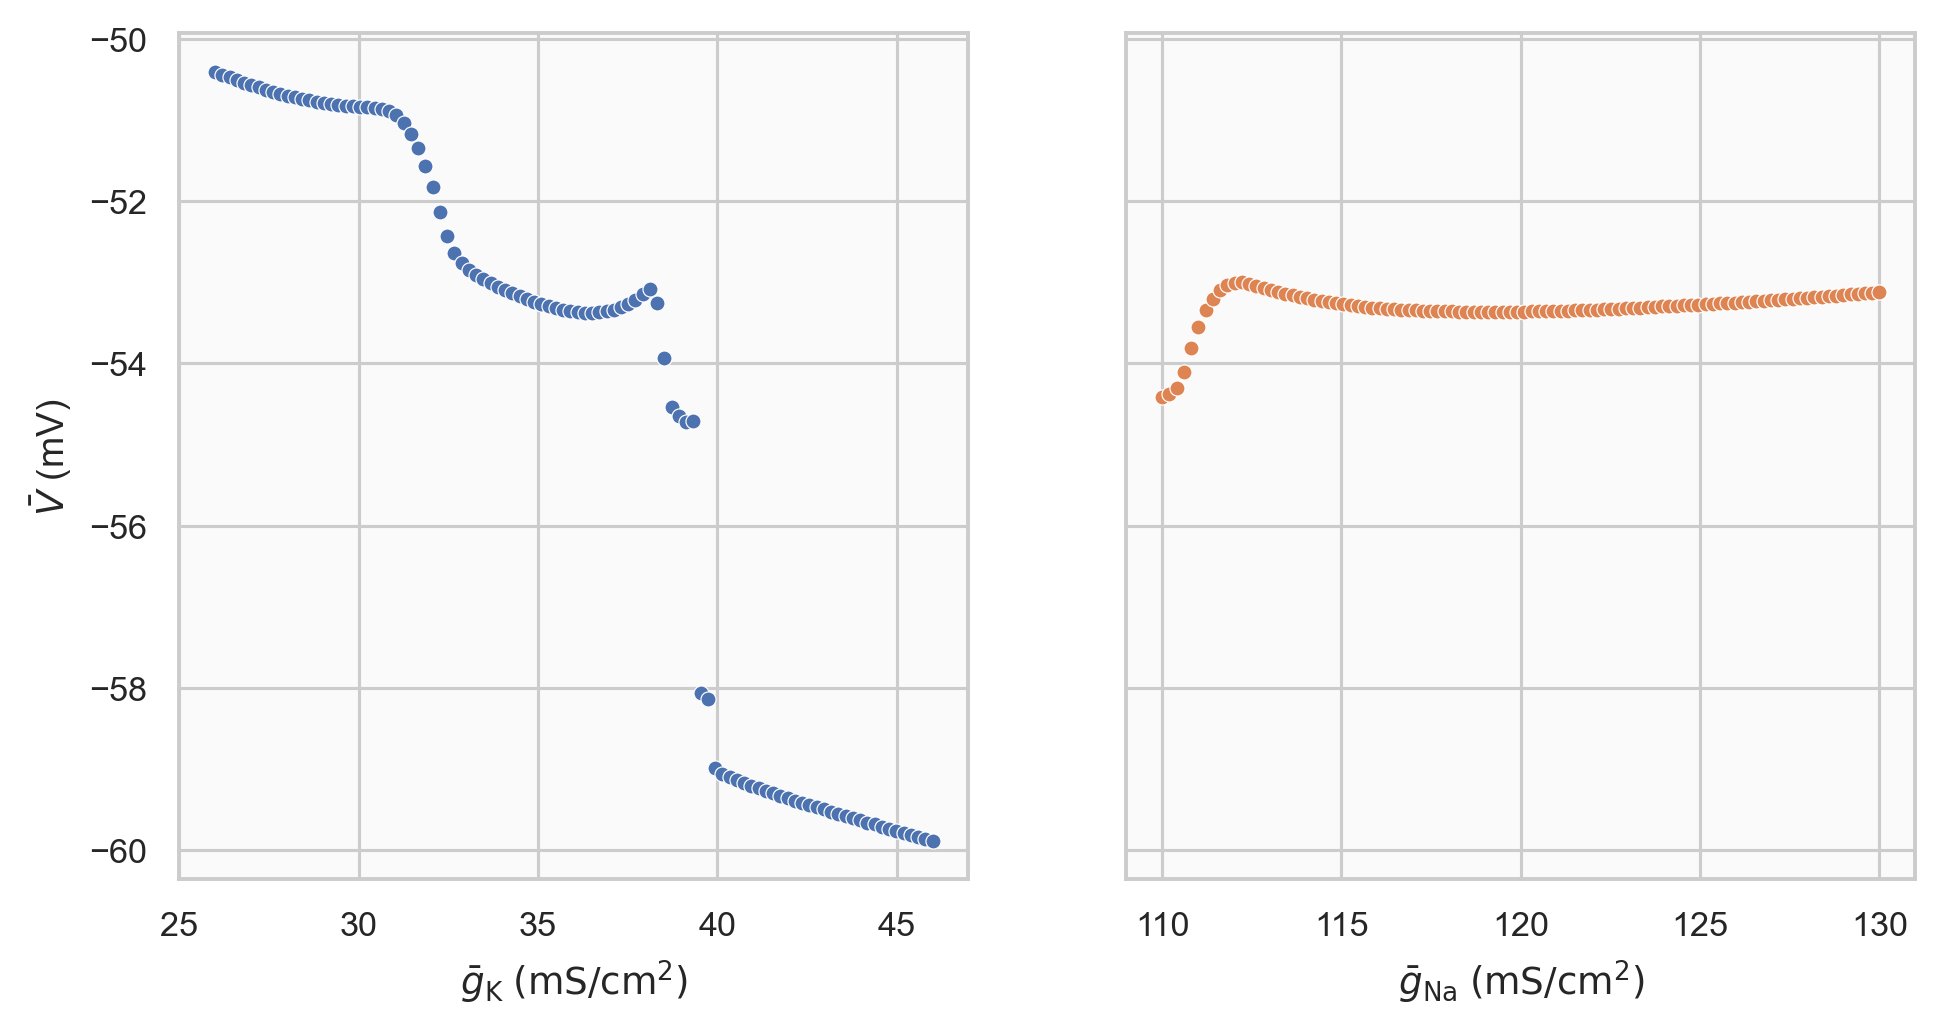

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="V_mean",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="V_mean", color="C1", s=15)
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$ $(\mathrm{mS/cm}^2)$",
            ylabel=r"$\bar{V}$ (mV)")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$ $(\mathrm{mS/cm}^2)$")
plt.show()

### In same plot

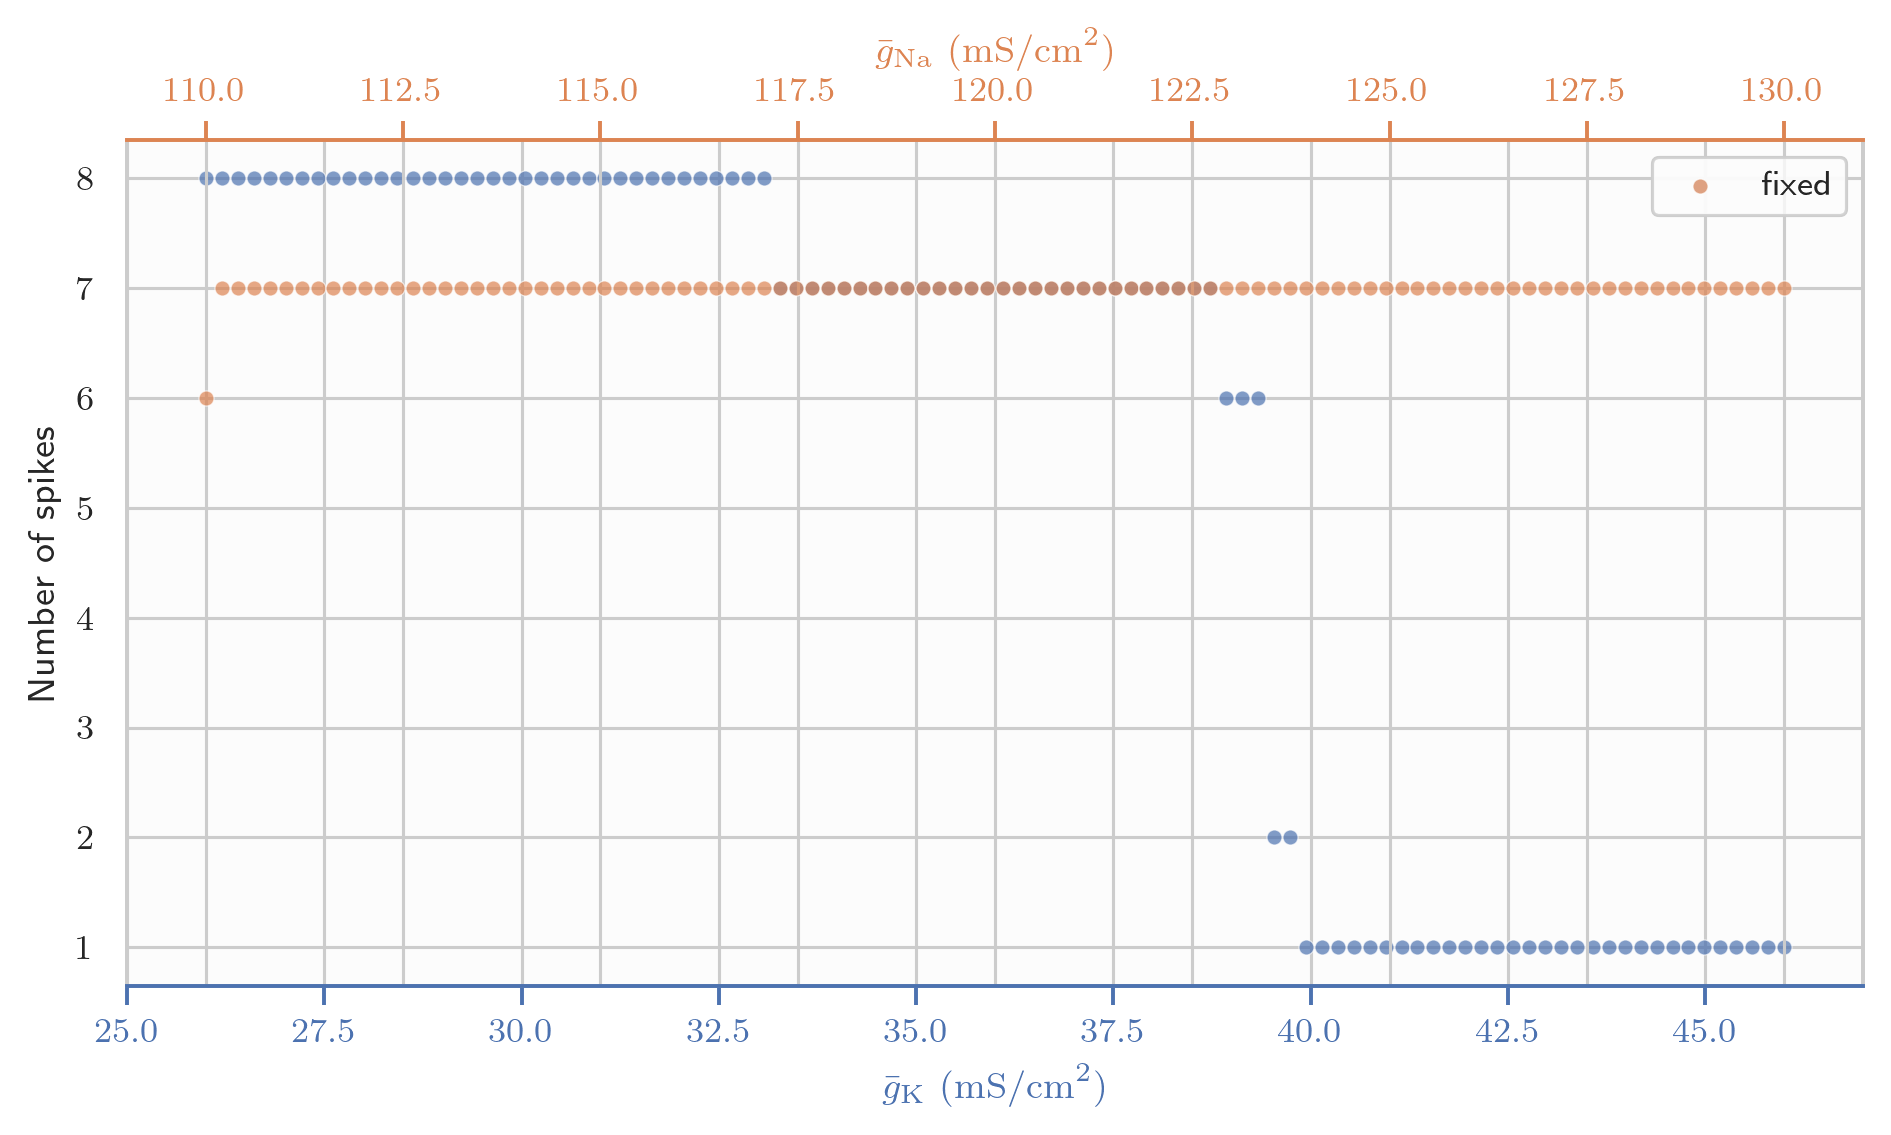

In [76]:
fig, ax1 = plt.subplots(figsize=(8, 4), dpi=140)

sns.scatterplot(data=df_gbar_K, 
                ax=ax1, 
                x="gbar_K", 
                y="n_spikes", 
                color="C0", 
                alpha=0.7, 
                s=15,
                label="fixed"
               )

ax1.set(xlabel=r"$\bar{g}_\mathrm{K}$ $(\mathrm{mS/cm}^2)$",
        ylabel=r"Number of spikes"
       )
 
ax1.legend()

ax2 = ax1.twiny() # ax1 and ax2 share y-axis

sns.scatterplot(data=df_gbar_Na, 
                ax=ax2, 
                x="gbar_Na", 
                y="n_spikes", 
                color="C1", 
                alpha=0.7,
                s=15,
                label="fixed"
               )

ax2.set_xlabel(r"$\bar{g}_\mathrm{Na}$ $(\mathrm{mS/cm}^2)$") 
ax2.legend()

ax1.tick_params(axis='x', colors='C0')
ax1.xaxis.label.set_color('C0')
ax2.tick_params(axis='x', colors='C1')
ax2.xaxis.label.set_color('C1')

ax2.spines['bottom'].set_color('C0')
ax2.spines['top'].set_color('C1')

plt.show()

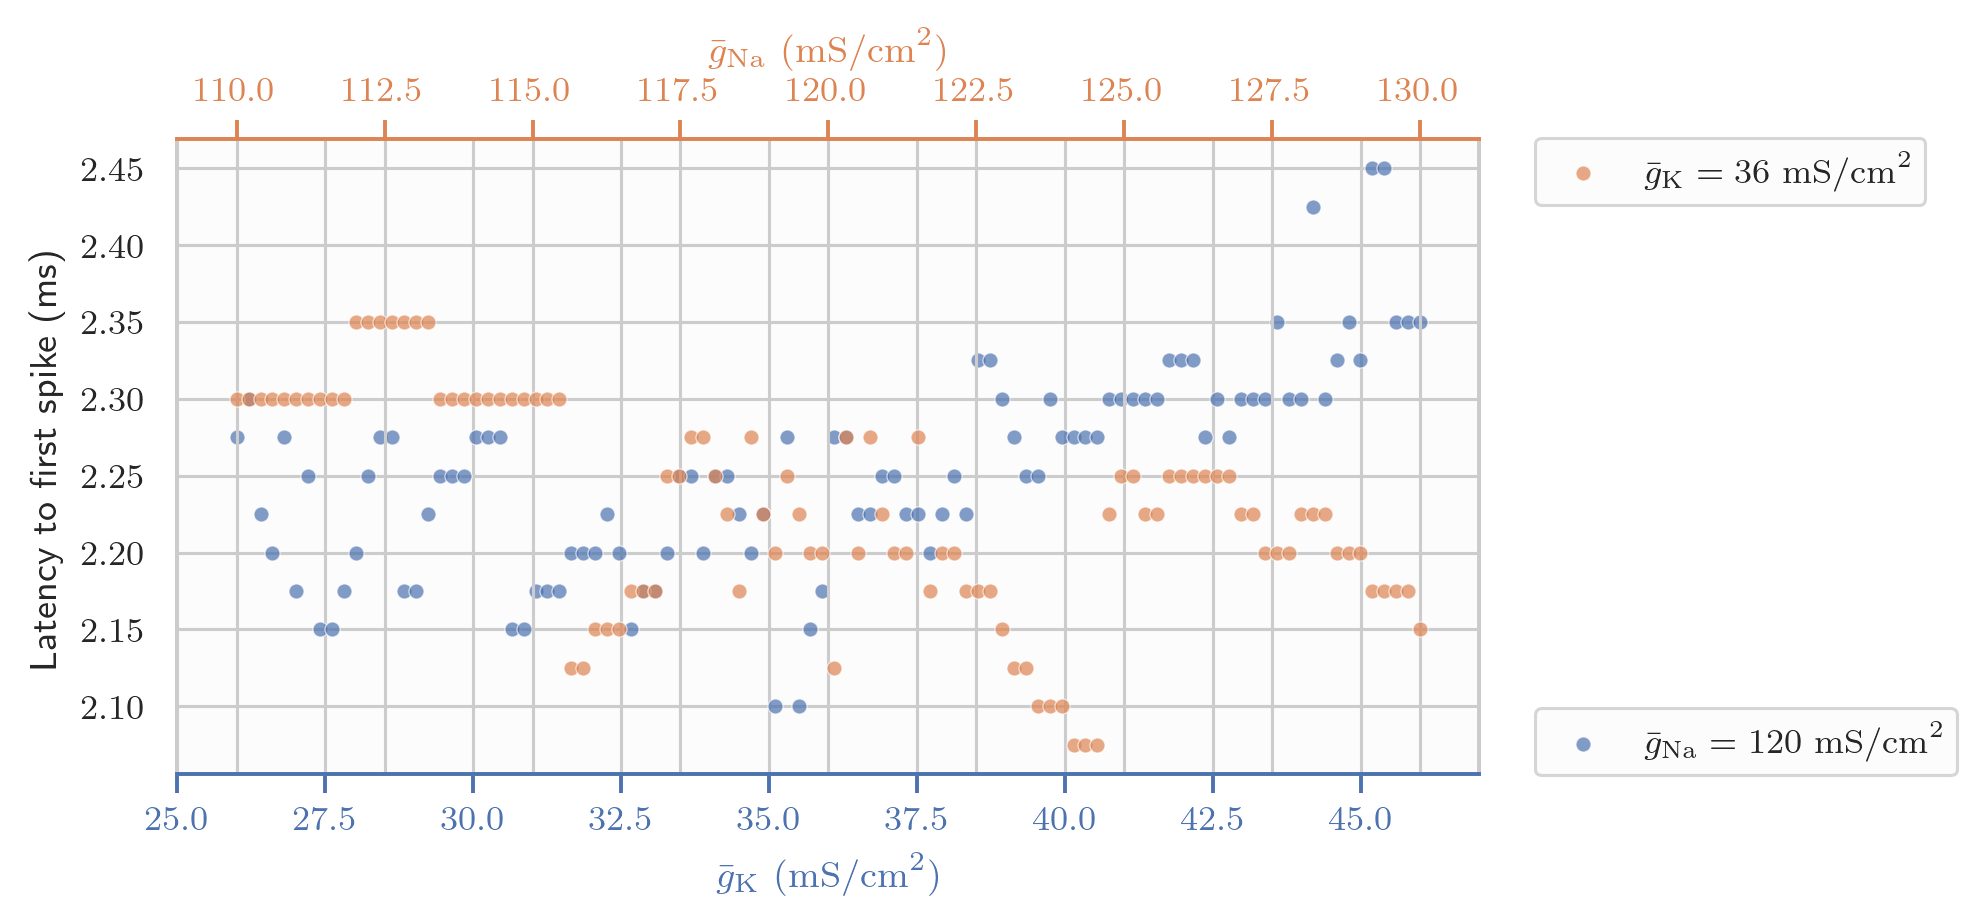

In [92]:
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=140)

ax1_label = fr"$\bar{{g}}_\mathrm{{Na}}={gbar_Na_fixed}$ $\mathrm{{mS/cm}}^2$"
ax2_label = fr"$\bar{{g}}_\mathrm{{K}}={gbar_K_fixed}$ $\mathrm{{mS/cm}}^2$"

sns.scatterplot(data=df_gbar_K, 
                ax=ax1, 
                x="gbar_K", 
                y="latency_to_first_spike", 
                color="C0", 
                alpha=0.7, 
                s=15,
                label=ax1_label
               )

ax1.set(xlabel=r"$\bar{g}_\mathrm{K}$ $(\mathrm{mS/cm}^2)$",
        ylabel=r"Latency to first spike (ms)"
       )
 

ax1.legend(loc="center left", 
           bbox_to_anchor=(1.04, 0.05),
           fancybox=True,
           borderaxespad=0.1,
          )

#ax1.legend(loc="lower right")

ax2 = ax1.twiny() # ax1 and ax2 share y-axis

sns.scatterplot(data=df_gbar_Na, 
                ax=ax2, 
                x="gbar_Na", 
                y="latency_to_first_spike", 
                color="C1", 
                alpha=0.7,
                s=15,
                label=ax2_label
               )

ax2.set_xlabel(r"$\bar{g}_\mathrm{Na}$ $(\mathrm{mS/cm}^2)$") 

ax2.legend(loc="center left", 
           bbox_to_anchor=(1.04, 0.95),
           fancybox=True,
           borderaxespad=0.1,
          )

#ax2.legend(loc="upper right")

ax1.tick_params(axis='x', colors='C0')
ax1.xaxis.label.set_color('C0')
ax2.tick_params(axis='x', colors='C1')
ax2.xaxis.label.set_color('C1')

ax2.spines['bottom'].set_color('C0')
ax2.spines['top'].set_color('C1')

plt.show()

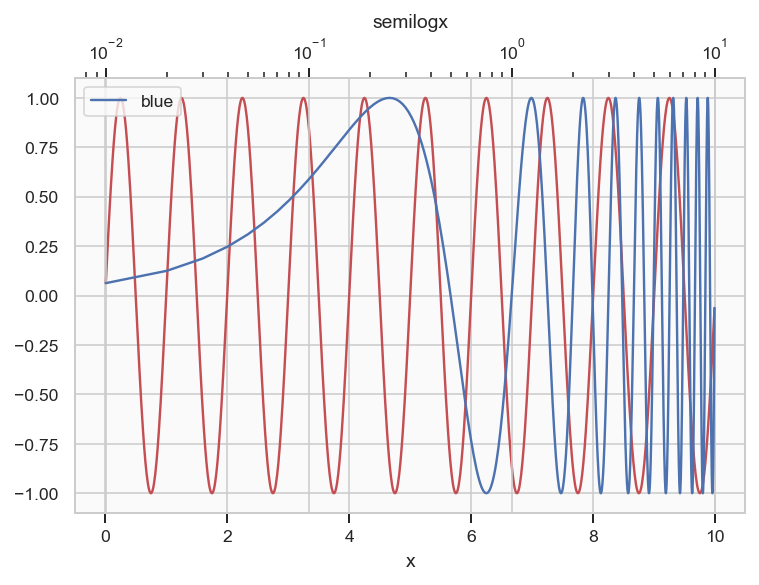

In [71]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

x = np.arange(0.01, 10.0, 0.01) # x-axis range
y = np.sin(2*np.pi*x) # simulated signal to plot

ax1.plot(x, y, color="r", label='red') # regular plot (red)
ax1.set_xlabel('x')

ax2 = ax1.twiny() # ax1 and ax2 share y-axis
ax2.semilogx(x, y, color="b", label='blue') # semilog plot (blue)
ax2.set_xlabel('semilogx')
plt.legend()
plt.show()

### End in same plot

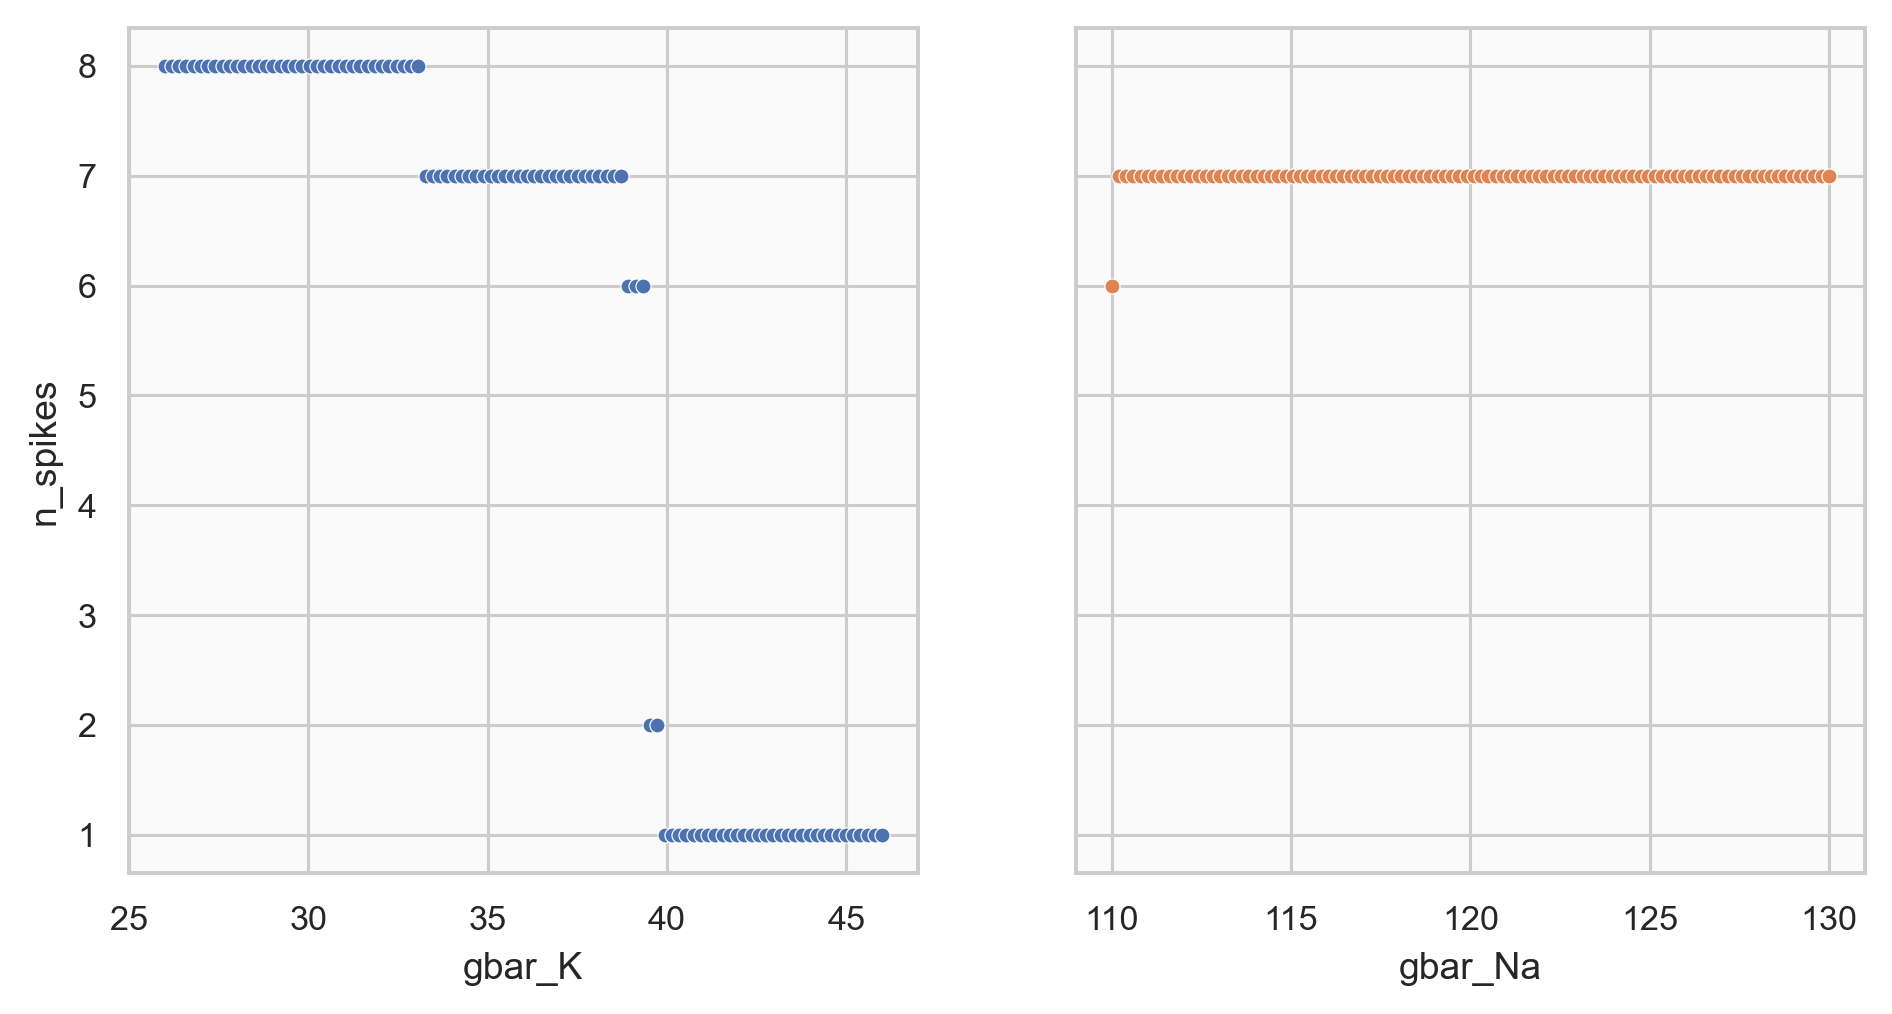

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="n_spikes", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="n_spikes", color="C1", s=15)
plt.show()

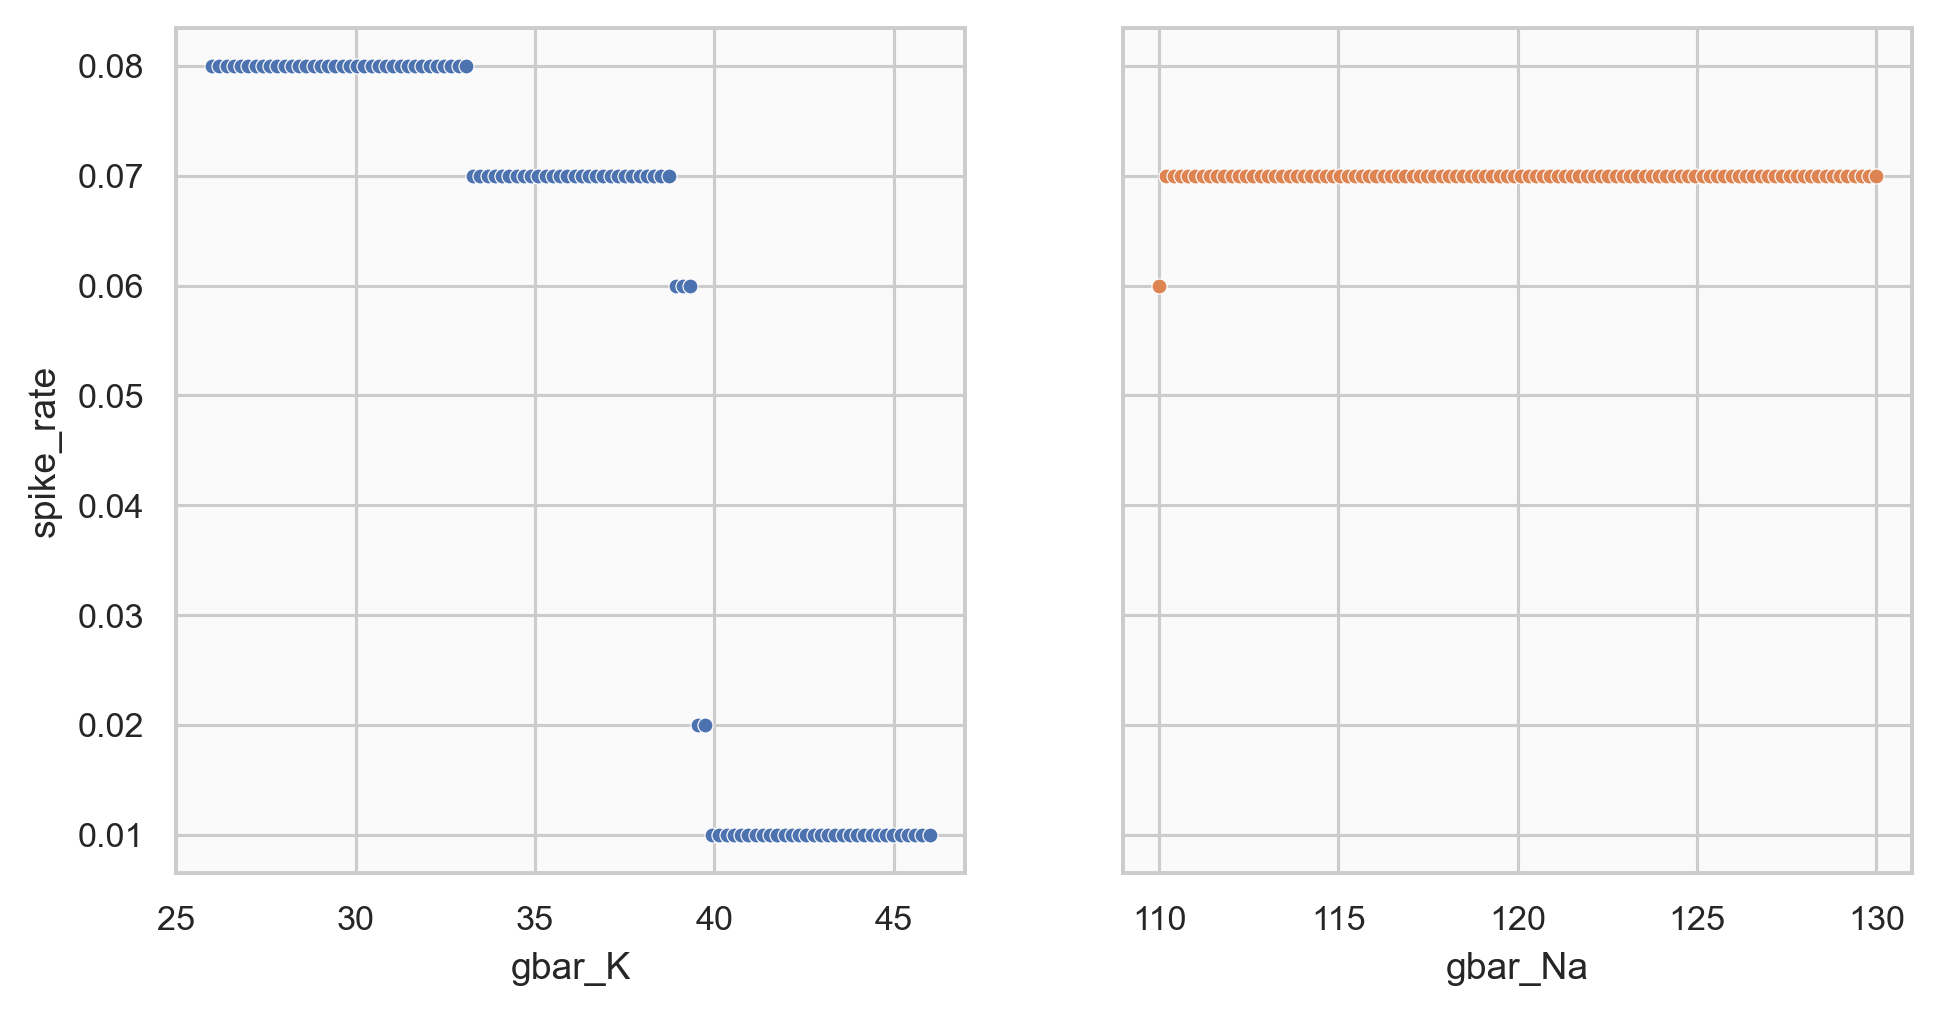

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="spike_rate", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="spike_rate", color="C1", s=15)
plt.show()

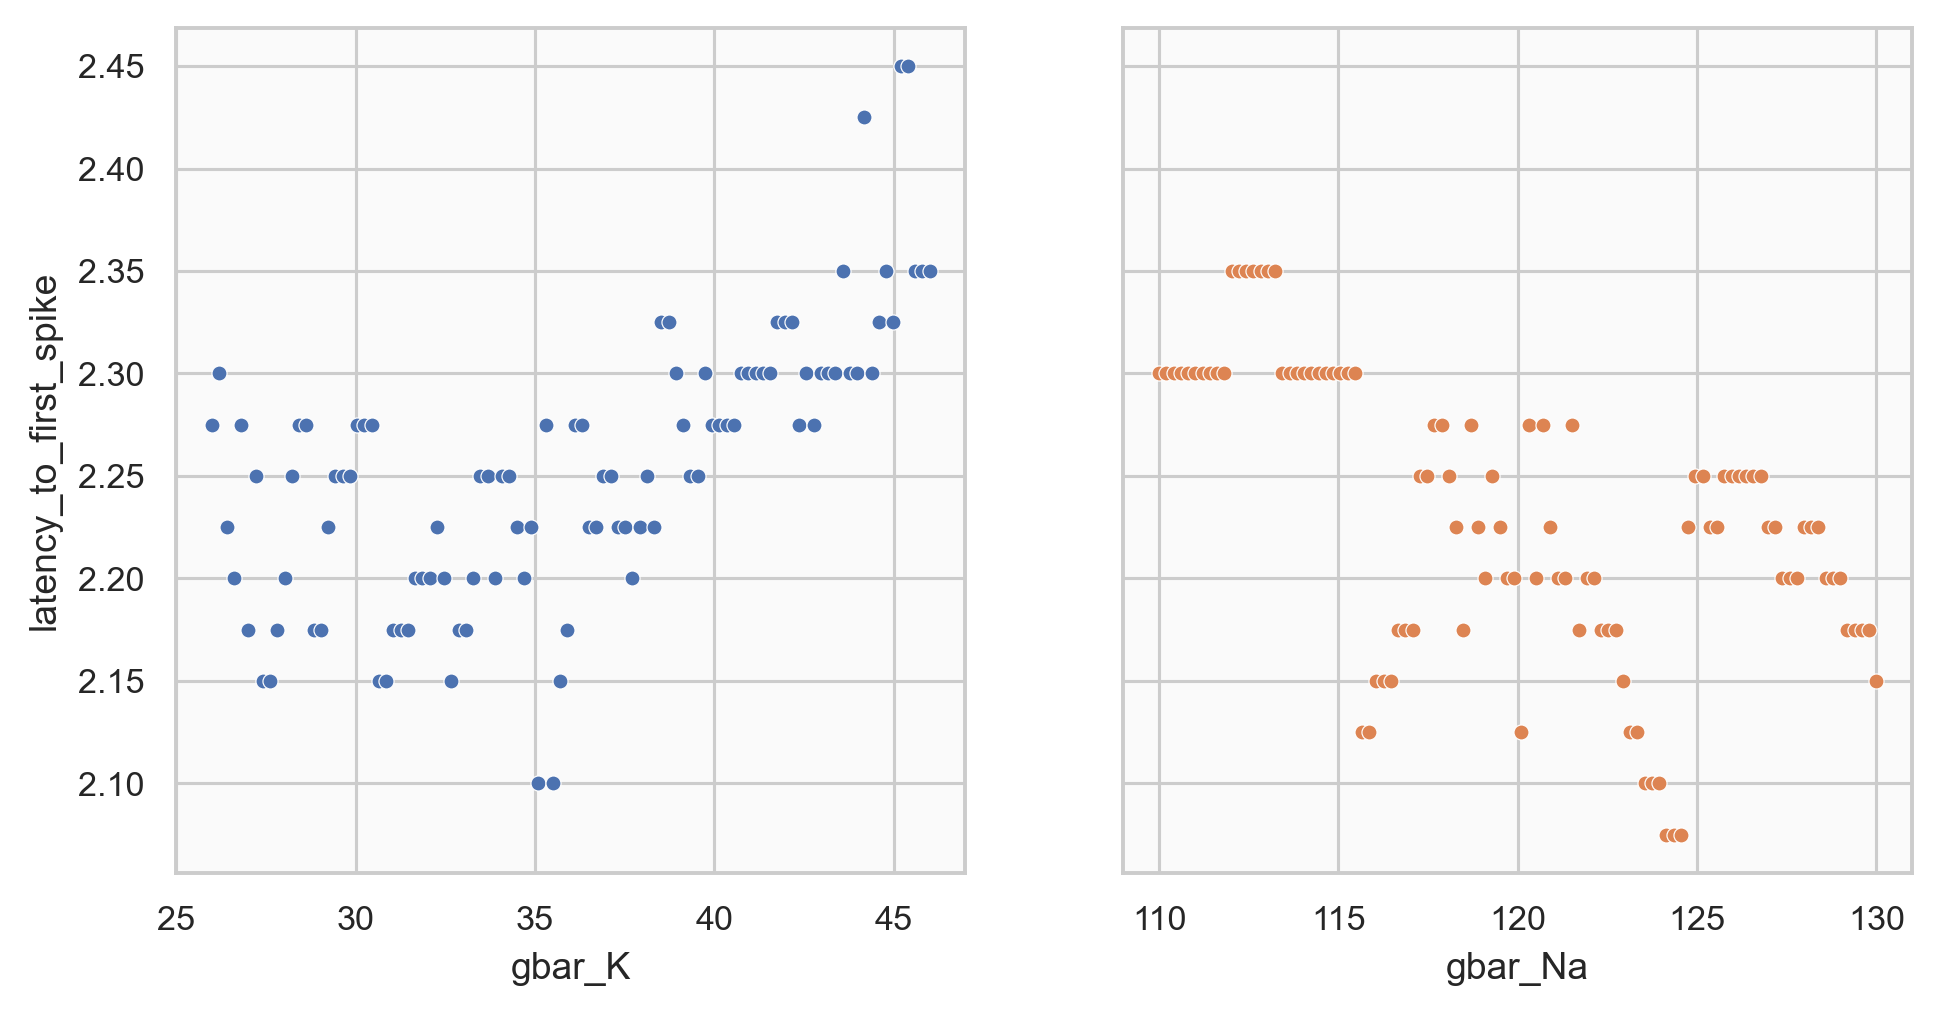

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="latency_to_first_spike", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="latency_to_first_spike", color="C1", s=15)
plt.show()

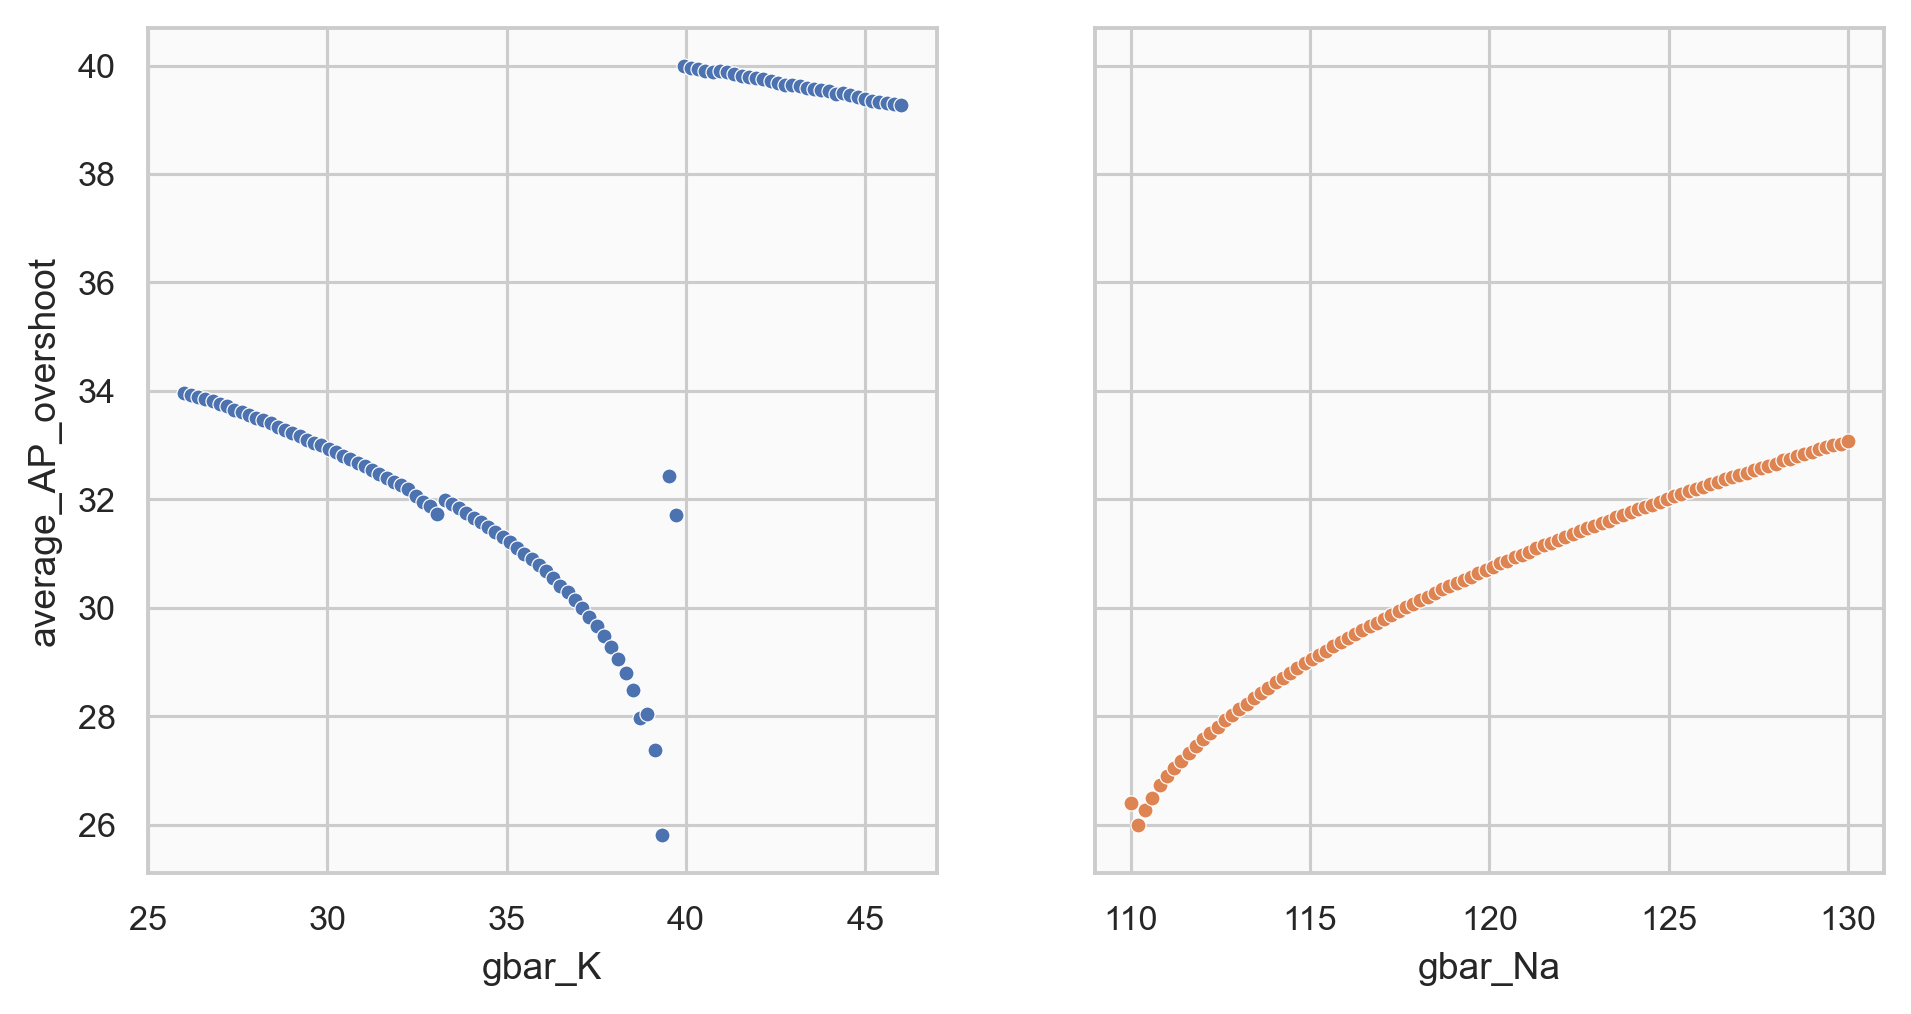

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="average_AP_overshoot", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="average_AP_overshoot", color="C1", s=15)
plt.show()

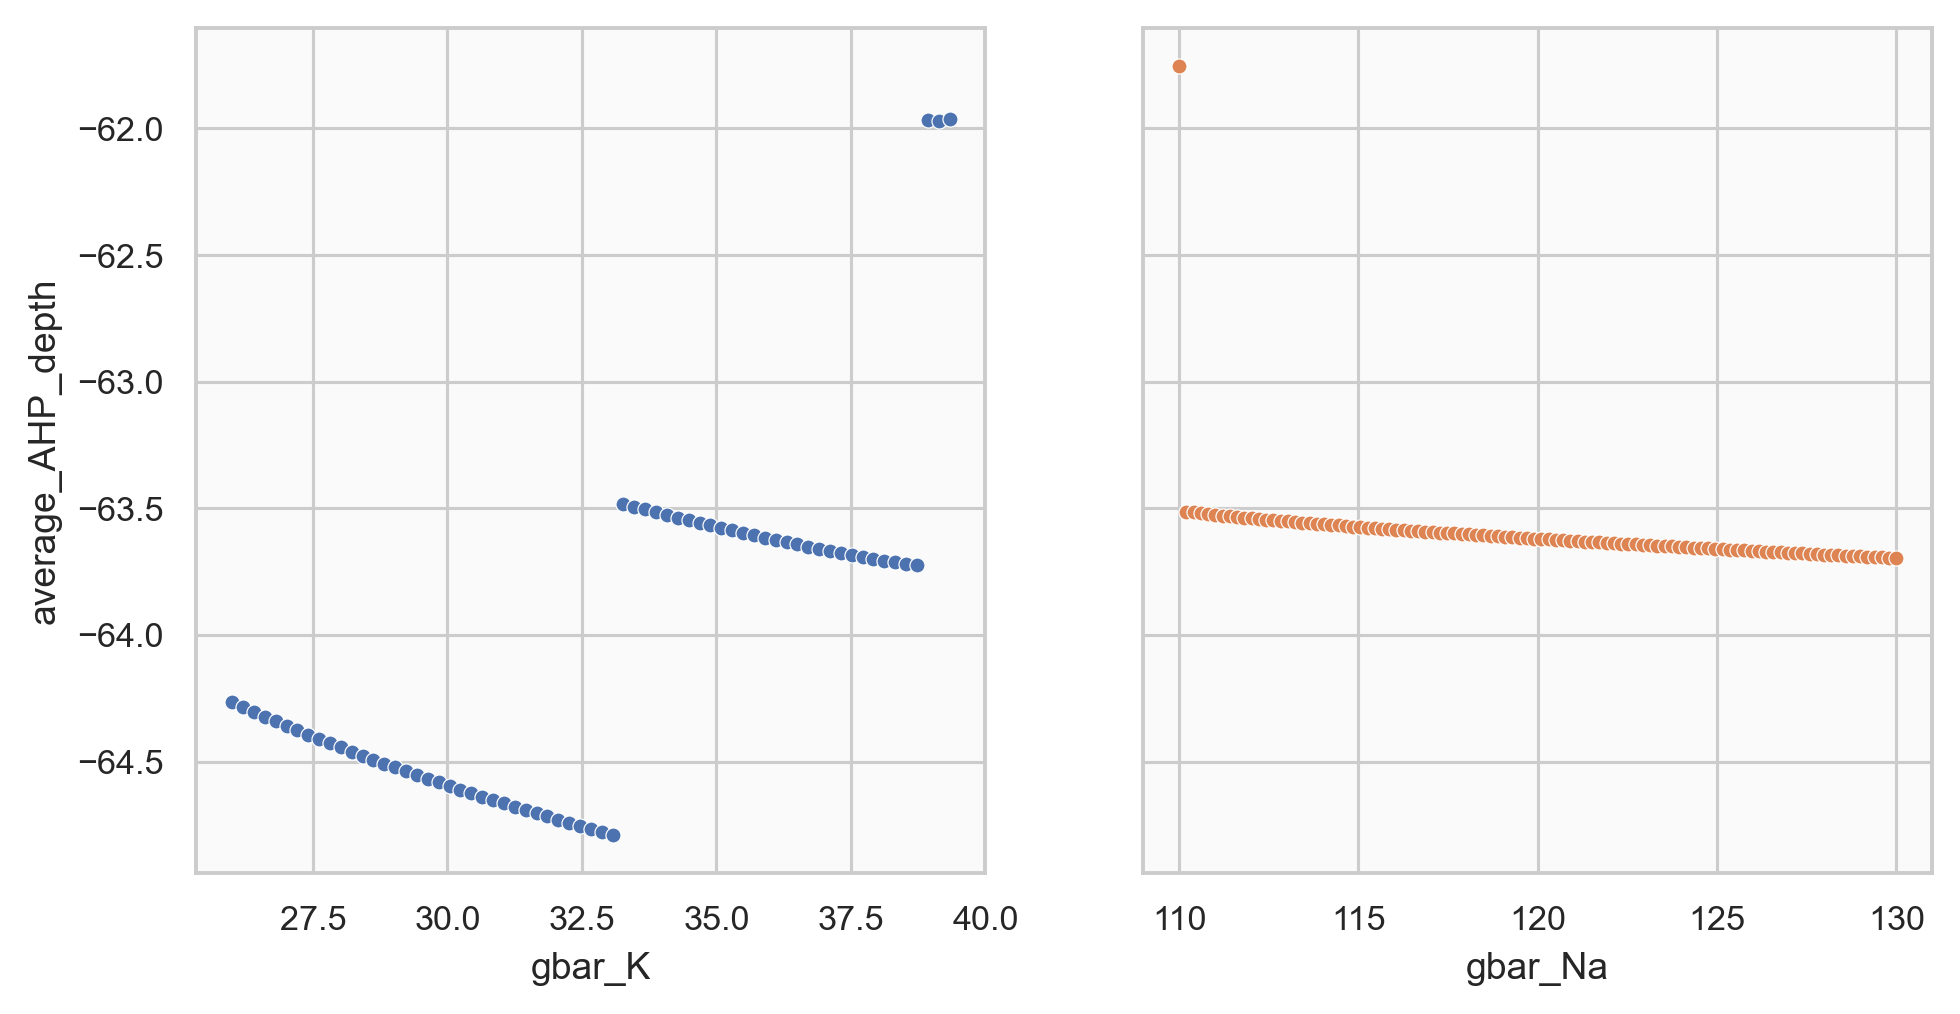

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="average_AHP_depth", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="average_AHP_depth", color="C1", s=15)
plt.show()

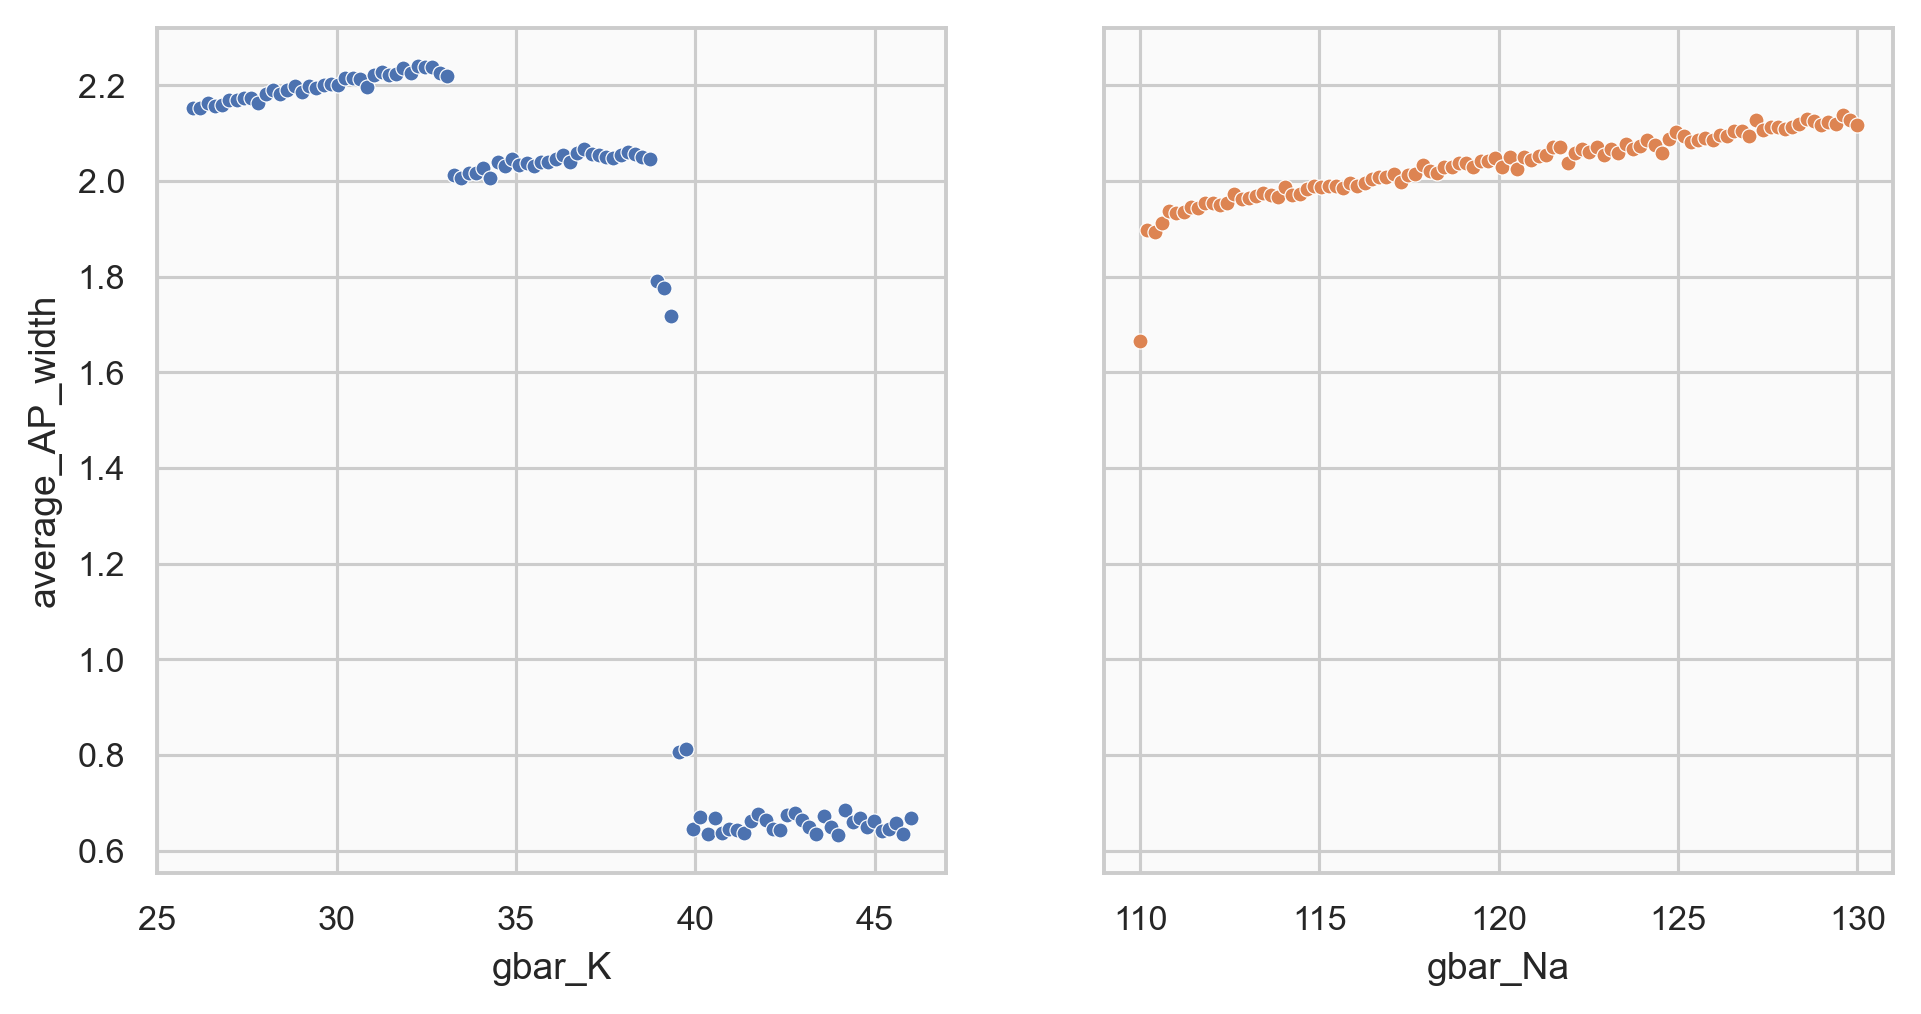

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="average_AP_width", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="average_AP_width", color="C1", s=15)
plt.show()

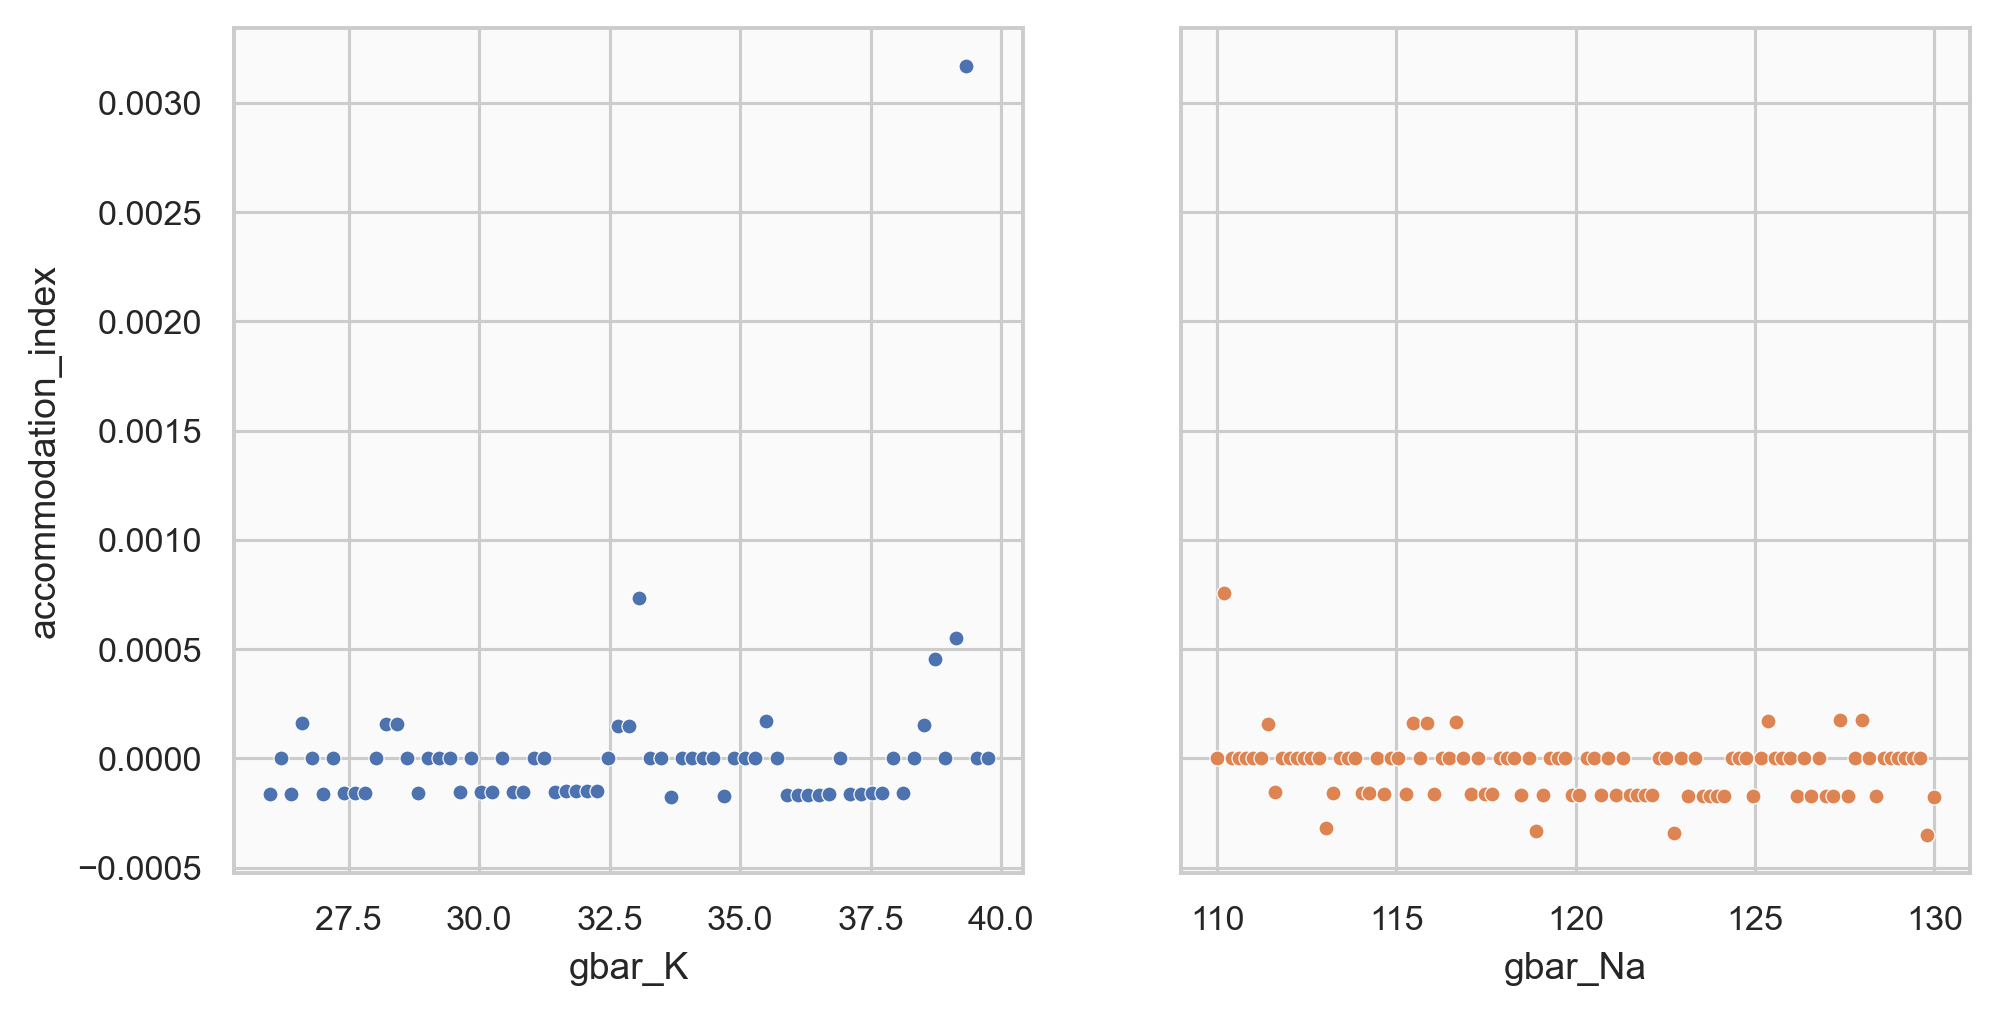

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=140, sharey=True)
sns.scatterplot(data=df_gbar_K, ax=axes[0], x="gbar_K", y="accommodation_index", color="C0", s=15)
sns.scatterplot(data=df_gbar_Na, ax=axes[1], x="gbar_Na", y="accommodation_index", color="C1", s=15)
plt.show()

### Examples

In [ ]:
# Simulate data from a bivariate Gaussian
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, .2)]
rng = np.random.RandomState(0)
x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)
plt.show()

In [ ]:
diamonds = sns.load_dataset("diamonds")
diamonds

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="carat", y="price",
                hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=diamonds, ax=ax)
plt.show()